In [1]:
import os
import gc
import json
import unidecode
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset

import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import VGG19_Weights

import optuna
import wandb
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from datetime import datetime

import import_ipynb

######## 

from DATA_AND_MODELS import VanGoghDataset,VanGoghModel

wandb.login(key='ba8ed449ca151ad3f490026aec87d75b7171a16d')


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/gabriel/.netrc
wandb: Currently logged in as: gabi-dadashev (gabi-dadashev-tel-aviv-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
def early_stop_check(patience, best_val_loss, best_val_loss_epoch, current_val_loss, current_val_loss_epoch):
    early_stop_flag = False  
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        best_val_loss_epoch = current_val_loss_epoch
    else:
        if current_val_loss_epoch - best_val_loss_epoch > patience:
            early_stop_flag = True  
    return best_val_loss, best_val_loss_epoch, early_stop_flag


In [3]:
def train_model_with_hyperparams(model, train_loader, val_loader, optimizer, criterion, epochs, patience):
    print('train_model_with_hyperparams')
    
    best_val_loss = float('inf')
    best_val_loss_epoch = 0  
    early_stop_flag = False
    best_model_state = None  

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    val_f1s = []
    val_aucs = []

    for epoch in range(1, epochs + 1):
        
        ### Training Loop
        model.train() 
        epoch_train_loss = 0.0 
        total_train_samples = 0 
        correct_train_predictions = 0 
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad() 
            
            outputs = model(inputs).squeeze(1)  
            loss = criterion(outputs.view(-1), labels)
            loss.backward() 
            optimizer.step()  

            epoch_train_loss += loss.item() * inputs.size(0)
            total_train_samples += inputs.size(0)
            
            preds_train = (outputs > 0.5).float()
            correct_train_predictions += (preds_train == labels).sum().item()

        epoch_train_loss /= total_train_samples
        train_accuracy = correct_train_predictions / total_train_samples

        ### Validation Loop
        model.eval()  
        epoch_val_loss = 0.0 
        total_val_samples = 0 
        correct_val_predictions = 0

        all_val_labels = []
        all_val_preds = []
        all_val_probs = []

        with torch.no_grad(): 
            for inputs, labels in val_loader: 
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze(1)  # outputs shape: (batch_size)
                loss = criterion(outputs.view(-1), labels)

                epoch_val_loss += loss.item() * inputs.size(0)
                total_val_samples += inputs.size(0)
                
                preds = (outputs > 0.5).float()
                
                correct_val_predictions += (preds == labels).sum().item()

                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(preds.cpu().numpy())
                all_val_probs.extend(outputs.cpu().numpy())

        epoch_val_loss /= total_val_samples
        val_accuracy = correct_val_predictions / total_val_samples

        if len(np.unique(all_val_labels)) > 1:
            val_f1 = f1_score(all_val_labels, all_val_preds)
            val_auc = roc_auc_score(all_val_labels, all_val_probs)
        else:
            val_f1 = 0
            val_auc = 0

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        val_f1s.append(val_f1)
        val_aucs.append(val_auc)

        best_val_loss, best_val_loss_epoch, early_stop_flag = early_stop_check(patience, best_val_loss, best_val_loss_epoch, epoch_val_loss, epoch)
        if epoch_val_loss == best_val_loss:
            best_model_state = model.state_dict()

        print(f"Epoch {epoch}: Train Loss = {epoch_train_loss:.4f}, Val Loss = {epoch_val_loss:.4f}, Train Acc = {train_accuracy:.4f}, Val Acc = {val_accuracy:.4f}, Val F1 = {val_f1:.4f}, Val AUC = {val_auc:.4f}")

        if early_stop_flag: 
            break 

    if best_model_state is not None: 
        now = datetime.now()
        torch.save(best_model_state, f"best_model_trial_{now.strftime('%H:%M:%S')}.pt") 

    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
    plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, val_f1s, label="Validation F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("Validation F1 Score")
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, val_aucs, label="Validation AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.title("Validation AUC")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return best_val_loss


In [4]:
classes = pd.read_csv("classes.csv", encoding="utf-8")
classes=classes[['filename', 'artist', 'genre', 'description', 'phash', 'width','height', 'genre_count']].copy()
classes_only_post_impressionism = classes[classes["filename"].str.contains('Post_Impressionism', case=False, na=False)].copy()
classes_only_post_impressionism['is_van_gogh'] = np.where(classes_only_post_impressionism['artist'] == 'vincent van gogh', 1, 0)
classes_only_post_impressionism=classes_only_post_impressionism.reset_index(drop=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 


In [5]:
dataset = VanGoghDataset(dataframe=classes_only_post_impressionism)


***Train VGG19***

--- Fold 1/5 ---


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


train_model_with_hyperparams
Epoch 1: Train Loss = 0.2931, Val Loss = 0.2175, Train Acc = 0.8825, Val Acc = 0.9097, Val F1 = 0.6346, Val AUC = 0.9379
Epoch 2: Train Loss = 0.1964, Val Loss = 0.2012, Train Acc = 0.9203, Val Acc = 0.9239, Val F1 = 0.7588, Val AUC = 0.9518
Epoch 3: Train Loss = 0.1724, Val Loss = 0.1721, Train Acc = 0.9344, Val Acc = 0.9334, Val F1 = 0.7730, Val AUC = 0.9599
Epoch 4: Train Loss = 0.1348, Val Loss = 0.1799, Train Acc = 0.9467, Val Acc = 0.9334, Val F1 = 0.7572, Val AUC = 0.9610
Epoch 5: Train Loss = 0.1195, Val Loss = 0.1867, Train Acc = 0.9558, Val Acc = 0.9295, Val F1 = 0.7359, Val AUC = 0.9581
Epoch 6: Train Loss = 0.1035, Val Loss = 0.1680, Train Acc = 0.9602, Val Acc = 0.9255, Val F1 = 0.7638, Val AUC = 0.9679
Epoch 7: Train Loss = 0.0825, Val Loss = 0.1833, Train Acc = 0.9681, Val Acc = 0.9398, Val F1 = 0.7751, Val AUC = 0.9673
Epoch 8: Train Loss = 0.0836, Val Loss = 0.2077, Train Acc = 0.9659, Val Acc = 0.9342, Val F1 = 0.7608, Val AUC = 0.9608
Epo

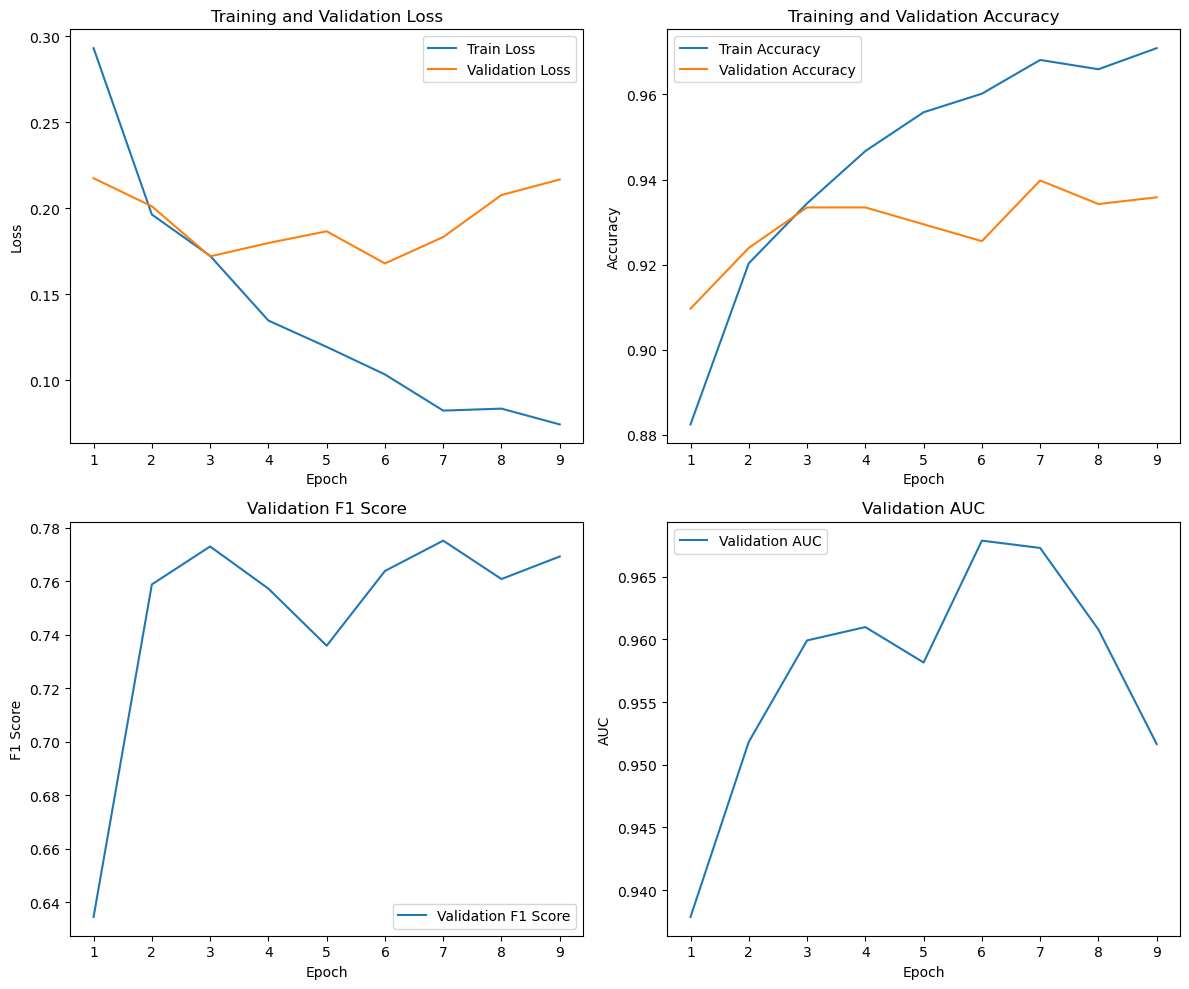

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.16798
fold,1
val_accuracy,0.93027
val_auc,0.95461
val_f1,0.75419


--- Fold 2/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.2913, Val Loss = 0.2463, Train Acc = 0.8838, Val Acc = 0.8994, Val F1 = 0.6613, Val AUC = 0.9269
Epoch 2: Train Loss = 0.1948, Val Loss = 0.2192, Train Acc = 0.9191, Val Acc = 0.9089, Val F1 = 0.7484, Val AUC = 0.9480
Epoch 3: Train Loss = 0.1578, Val Loss = 0.2038, Train Acc = 0.9397, Val Acc = 0.9271, Val F1 = 0.7830, Val AUC = 0.9479
Epoch 4: Train Loss = 0.1320, Val Loss = 0.2142, Train Acc = 0.9463, Val Acc = 0.9223, Val F1 = 0.7689, Val AUC = 0.9523
Epoch 5: Train Loss = 0.1175, Val Loss = 0.2429, Train Acc = 0.9526, Val Acc = 0.9152, Val F1 = 0.7084, Val AUC = 0.9446
Epoch 6: Train Loss = 0.0987, Val Loss = 0.2164, Train Acc = 0.9635, Val Acc = 0.9120, Val F1 = 0.7571, Val AUC = 0.9596


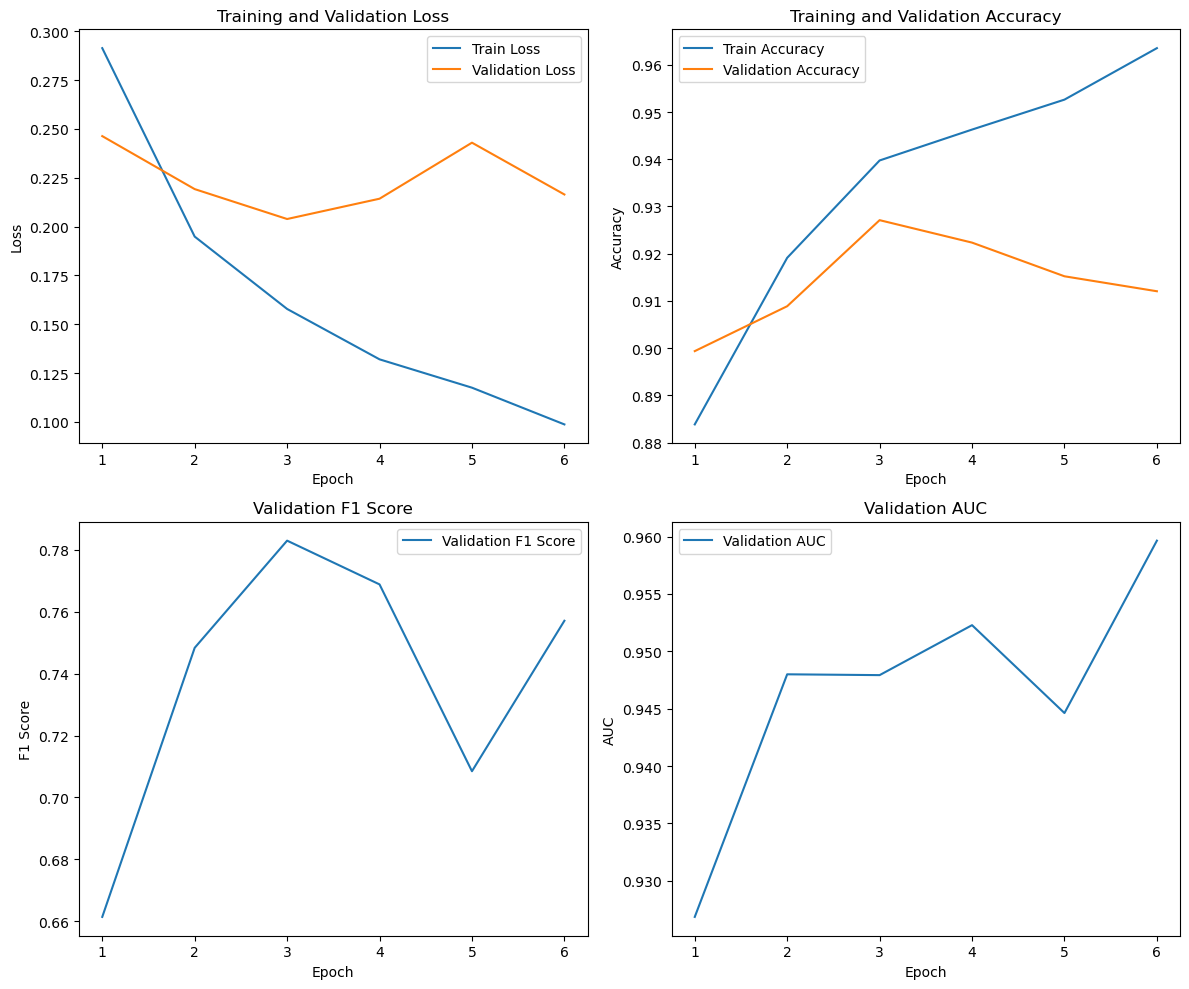

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.20384
fold,2
val_accuracy,0.91918
val_auc,0.94944
val_f1,0.77826


--- Fold 3/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.3010, Val Loss = 0.2090, Train Acc = 0.8777, Val Acc = 0.9136, Val F1 = 0.7348, Val AUC = 0.9478
Epoch 2: Train Loss = 0.1992, Val Loss = 0.1858, Train Acc = 0.9219, Val Acc = 0.9239, Val F1 = 0.7576, Val AUC = 0.9567
Epoch 3: Train Loss = 0.1617, Val Loss = 0.1678, Train Acc = 0.9388, Val Acc = 0.9342, Val F1 = 0.7909, Val AUC = 0.9646
Epoch 4: Train Loss = 0.1387, Val Loss = 0.1936, Train Acc = 0.9463, Val Acc = 0.9286, Val F1 = 0.7414, Val AUC = 0.9600
Epoch 5: Train Loss = 0.1157, Val Loss = 0.1757, Train Acc = 0.9546, Val Acc = 0.9366, Val F1 = 0.7980, Val AUC = 0.9624
Epoch 6: Train Loss = 0.0982, Val Loss = 0.1753, Train Acc = 0.9616, Val Acc = 0.9342, Val F1 = 0.7775, Val AUC = 0.9659


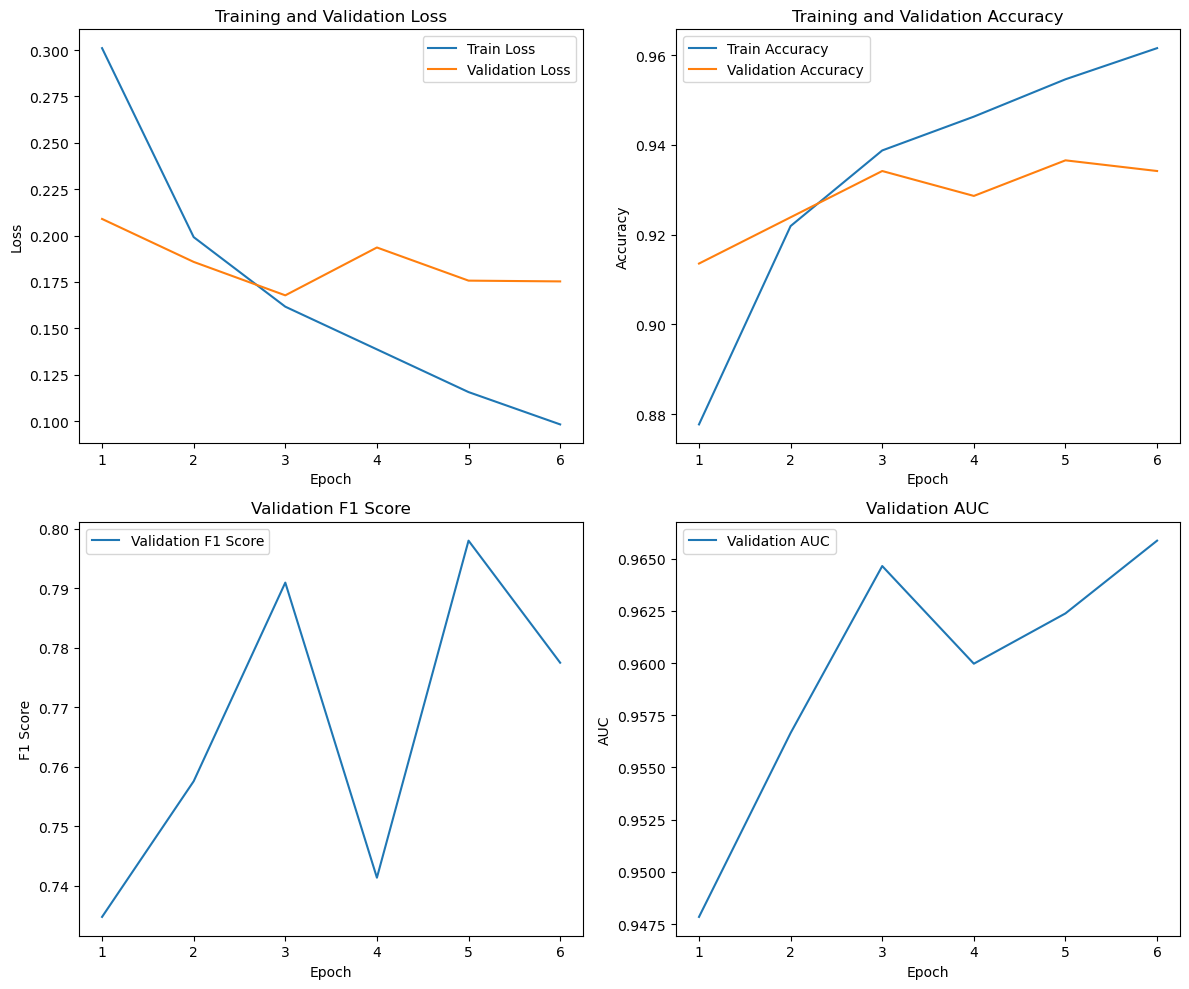

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.1678
fold,3
val_accuracy,0.93656
val_auc,0.9641
val_f1,0.78836


--- Fold 4/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.2953, Val Loss = 0.3350, Train Acc = 0.8763, Val Acc = 0.8295, Val F1 = 0.6208, Val AUC = 0.9308
Epoch 2: Train Loss = 0.1877, Val Loss = 0.2325, Train Acc = 0.9273, Val Acc = 0.9080, Val F1 = 0.6548, Val AUC = 0.9327
Epoch 3: Train Loss = 0.1622, Val Loss = 0.2446, Train Acc = 0.9372, Val Acc = 0.9262, Val F1 = 0.7365, Val AUC = 0.9406
Epoch 4: Train Loss = 0.1346, Val Loss = 0.2514, Train Acc = 0.9453, Val Acc = 0.9112, Val F1 = 0.7295, Val AUC = 0.9358
Epoch 5: Train Loss = 0.1043, Val Loss = 0.2601, Train Acc = 0.9582, Val Acc = 0.9191, Val F1 = 0.7135, Val AUC = 0.9341


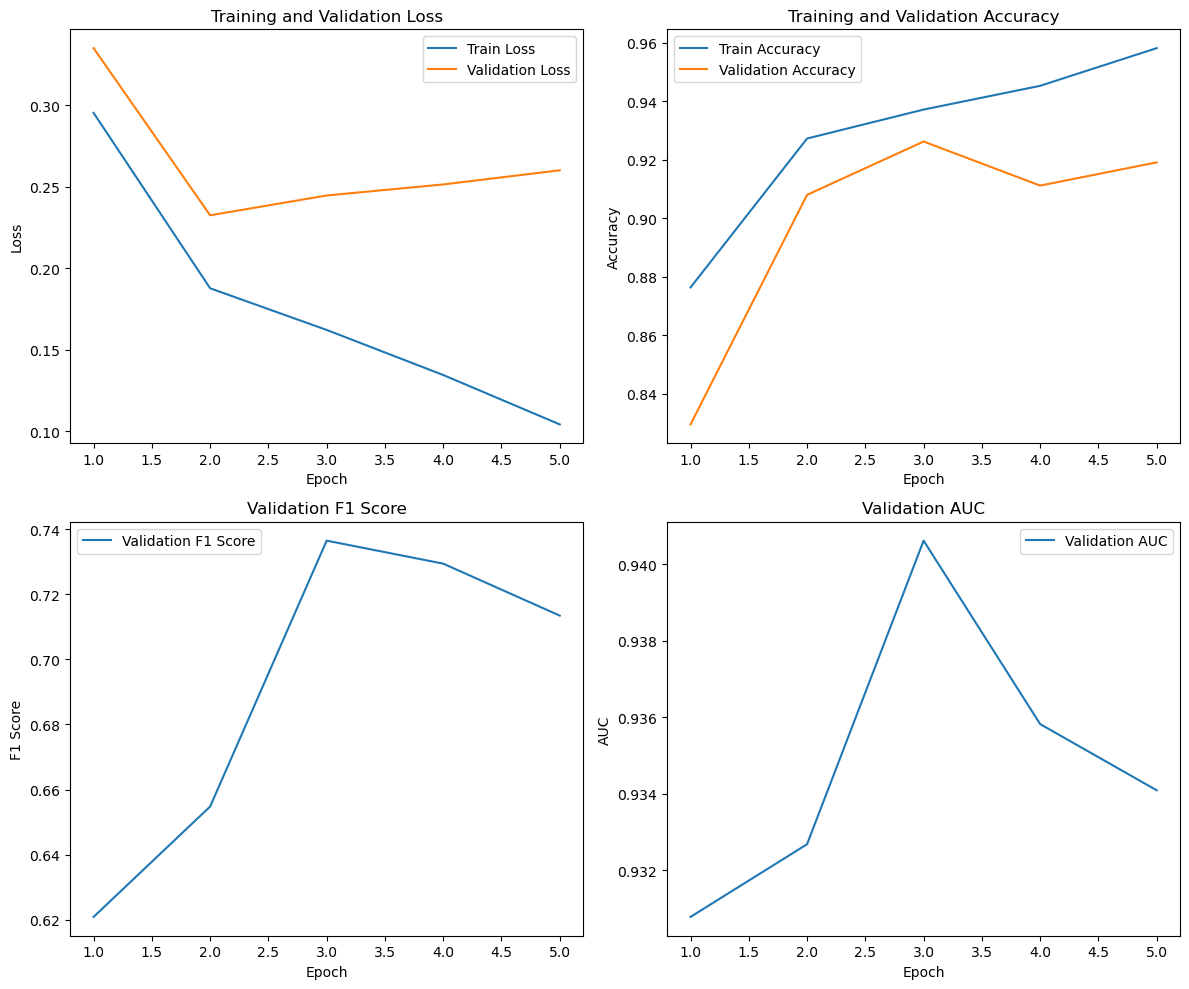

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.2325
fold,4
val_accuracy,0.92308
val_auc,0.93717
val_f1,0.7313


--- Fold 5/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.2884, Val Loss = 0.2084, Train Acc = 0.8825, Val Acc = 0.9183, Val F1 = 0.7282, Val AUC = 0.9465
Epoch 2: Train Loss = 0.1942, Val Loss = 0.1886, Train Acc = 0.9231, Val Acc = 0.9294, Val F1 = 0.7855, Val AUC = 0.9574
Epoch 3: Train Loss = 0.1628, Val Loss = 0.1716, Train Acc = 0.9348, Val Acc = 0.9310, Val F1 = 0.7763, Val AUC = 0.9620
Epoch 4: Train Loss = 0.1346, Val Loss = 0.1724, Train Acc = 0.9491, Val Acc = 0.9413, Val F1 = 0.7898, Val AUC = 0.9621
Epoch 5: Train Loss = 0.1216, Val Loss = 0.2024, Train Acc = 0.9514, Val Acc = 0.9223, Val F1 = 0.7487, Val AUC = 0.9542
Epoch 6: Train Loss = 0.1001, Val Loss = 0.2205, Train Acc = 0.9586, Val Acc = 0.9326, Val F1 = 0.7684, Val AUC = 0.9521


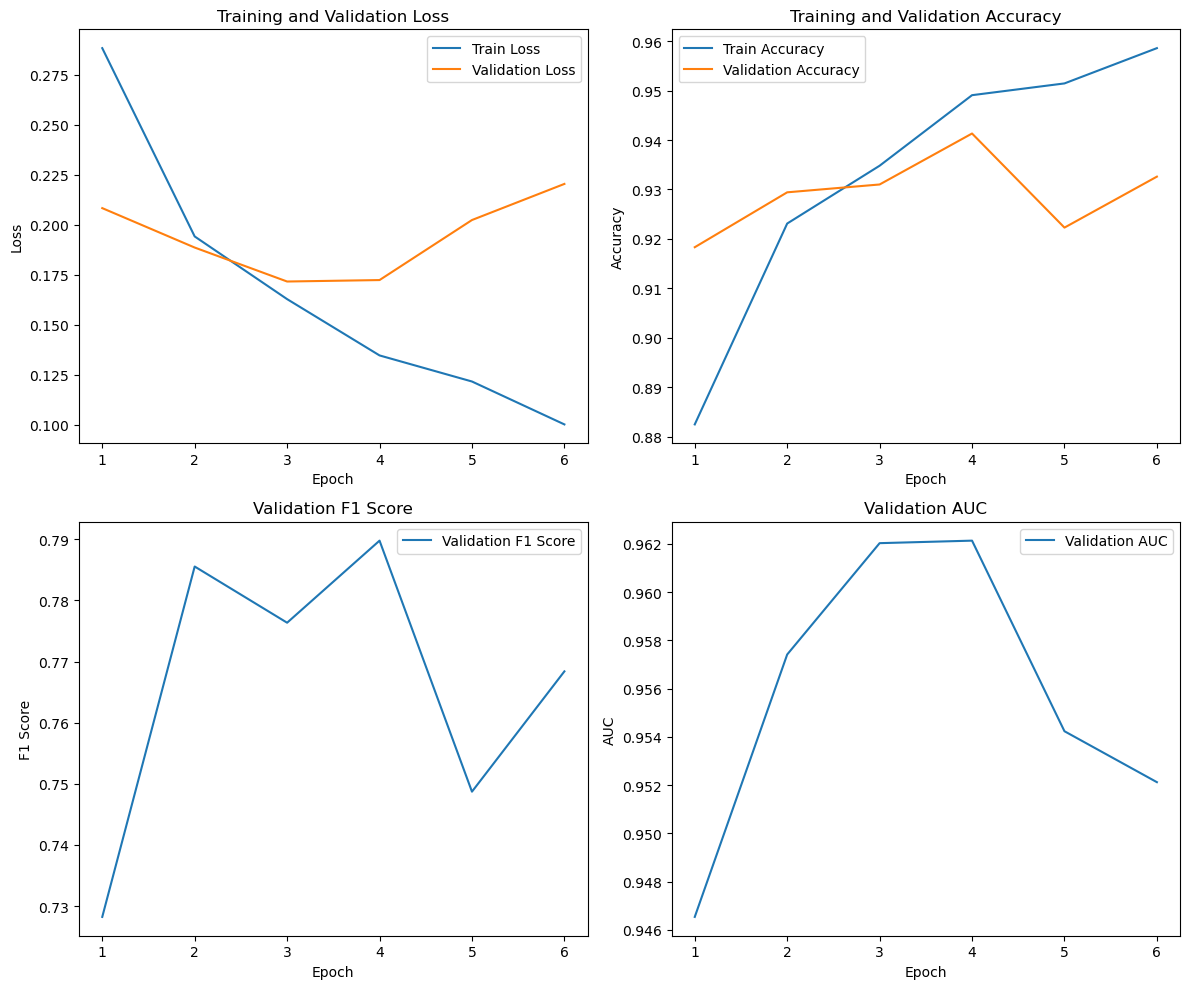

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.17164
fold,5
val_accuracy,0.92863
val_auc,0.95598
val_f1,0.7619


In [6]:
patience = 2
k_folds = 5  
epochs=13


learning_rate=0.000022012211629918463
weight_decay=0.000001549668920821374
batch_size = 4


kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_losses = []


for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    
    print(f"--- Fold {fold+1}/{k_folds} ---")

    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


    model_VGG19 = VanGoghModel(device,None,'VGG19').model

    optimizer_VGG19 = optim.Adam(model_VGG19.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion_VGG19 = nn.BCELoss()

    wandb.init(
        project="Train_VGG19",
        config={
            "model": "VGG19",  
            "learning_rate": learning_rate,
            "weight_decay": weight_decay,
            "batch_size": batch_size,
            "k_folds": k_folds,
            "epochs": epochs,      
            "patience": patience
        },
        name=f"VGG19_fold_{fold+1}"
    )

    best_val_loss_VGG19 = train_model_with_hyperparams(
        model_VGG19, train_loader, val_loader, optimizer_VGG19, criterion_VGG19,
        epochs=epochs, patience=patience
    )
    
    fold_losses.append(best_val_loss_VGG19)
    
    model_VGG19.eval()
    val_true = []
    val_pred = []
    val_probs = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_VGG19(inputs).squeeze(1)  
            probs = outputs  
            preds = (probs > 0.5).float()
    
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(preds.cpu().numpy())
            val_probs.extend(probs.cpu().numpy())

    
    acc = accuracy_score(val_true, val_pred)
    auc = roc_auc_score(val_true, val_probs)
    f1 = f1_score(val_true, val_pred)

   

    wandb.log({
        "fold": fold+1,
        "best_val_loss_VGG19": best_val_loss_VGG19,
        "val_accuracy": acc,
        "val_auc": auc,
        "val_f1": f1
    })
    
    wandb.finish()






***Train AlexNet***

--- Fold 1/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.2810, Val Loss = 0.1937, Train Acc = 0.8900, Val Acc = 0.9168, Val F1 = 0.7009, Val AUC = 0.9483
Epoch 2: Train Loss = 0.1939, Val Loss = 0.1755, Train Acc = 0.9203, Val Acc = 0.9326, Val F1 = 0.7550, Val AUC = 0.9572
Epoch 3: Train Loss = 0.1588, Val Loss = 0.1891, Train Acc = 0.9368, Val Acc = 0.9279, Val F1 = 0.7547, Val AUC = 0.9509
Epoch 4: Train Loss = 0.1389, Val Loss = 0.1672, Train Acc = 0.9435, Val Acc = 0.9350, Val F1 = 0.7887, Val AUC = 0.9633
Epoch 5: Train Loss = 0.1182, Val Loss = 0.1669, Train Acc = 0.9504, Val Acc = 0.9326, Val F1 = 0.7606, Val AUC = 0.9627
Epoch 6: Train Loss = 0.1039, Val Loss = 0.1681, Train Acc = 0.9596, Val Acc = 0.9319, Val F1 = 0.7817, Val AUC = 0.9636
Epoch 7: Train Loss = 0.0926, Val Loss = 0.2096, Train Acc = 0.9633, Val Acc = 0.9342, Val F1 = 0.7414, Val AUC = 0.9690
Epoch 8: Train Loss = 0.0779, Val Loss = 0.1578, Train Acc = 0.9689, Val Acc = 0.9382, Val F1 = 0.7990, Val AUC = 0.9711
Epo

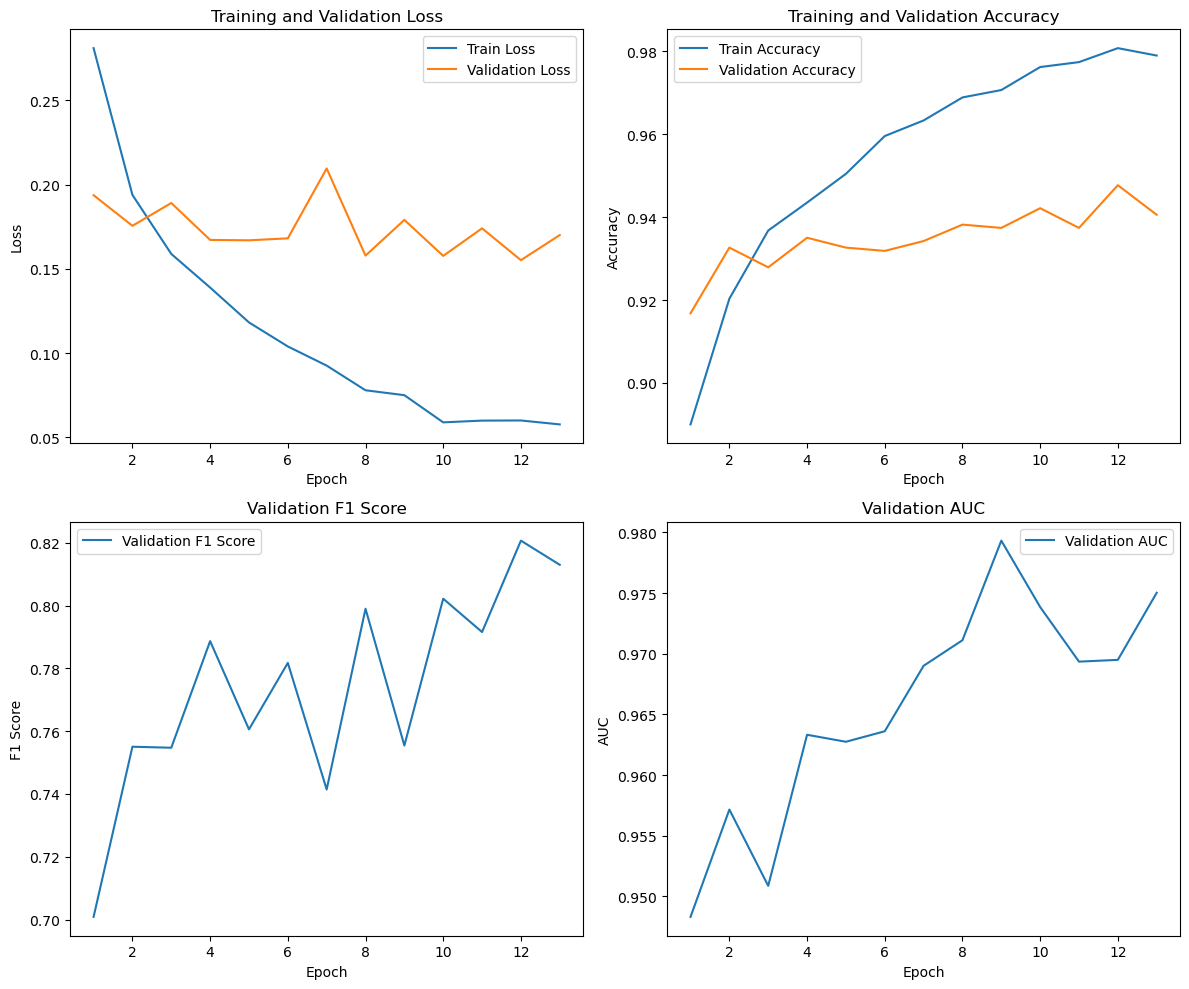

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.15514
fold,1
val_accuracy,0.93582
val_auc,0.97133
val_f1,0.79901


--- Fold 2/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.2695, Val Loss = 0.2470, Train Acc = 0.8914, Val Acc = 0.9041, Val F1 = 0.7206, Val AUC = 0.9286
Epoch 2: Train Loss = 0.1980, Val Loss = 0.2138, Train Acc = 0.9207, Val Acc = 0.9184, Val F1 = 0.7131, Val AUC = 0.9490
Epoch 3: Train Loss = 0.1627, Val Loss = 0.2279, Train Acc = 0.9354, Val Acc = 0.9184, Val F1 = 0.7163, Val AUC = 0.9475
Epoch 4: Train Loss = 0.1399, Val Loss = 0.1976, Train Acc = 0.9463, Val Acc = 0.9279, Val F1 = 0.7838, Val AUC = 0.9544
Epoch 5: Train Loss = 0.1233, Val Loss = 0.1776, Train Acc = 0.9495, Val Acc = 0.9350, Val F1 = 0.8066, Val AUC = 0.9617
Epoch 6: Train Loss = 0.1085, Val Loss = 0.1882, Train Acc = 0.9610, Val Acc = 0.9231, Val F1 = 0.7749, Val AUC = 0.9600
Epoch 7: Train Loss = 0.0982, Val Loss = 0.2030, Train Acc = 0.9592, Val Acc = 0.9374, Val F1 = 0.8049, Val AUC = 0.9642
Epoch 8: Train Loss = 0.0830, Val Loss = 0.2078, Train Acc = 0.9677, Val Acc = 0.9184, Val F1 = 0.7419, Val AUC = 0.9561


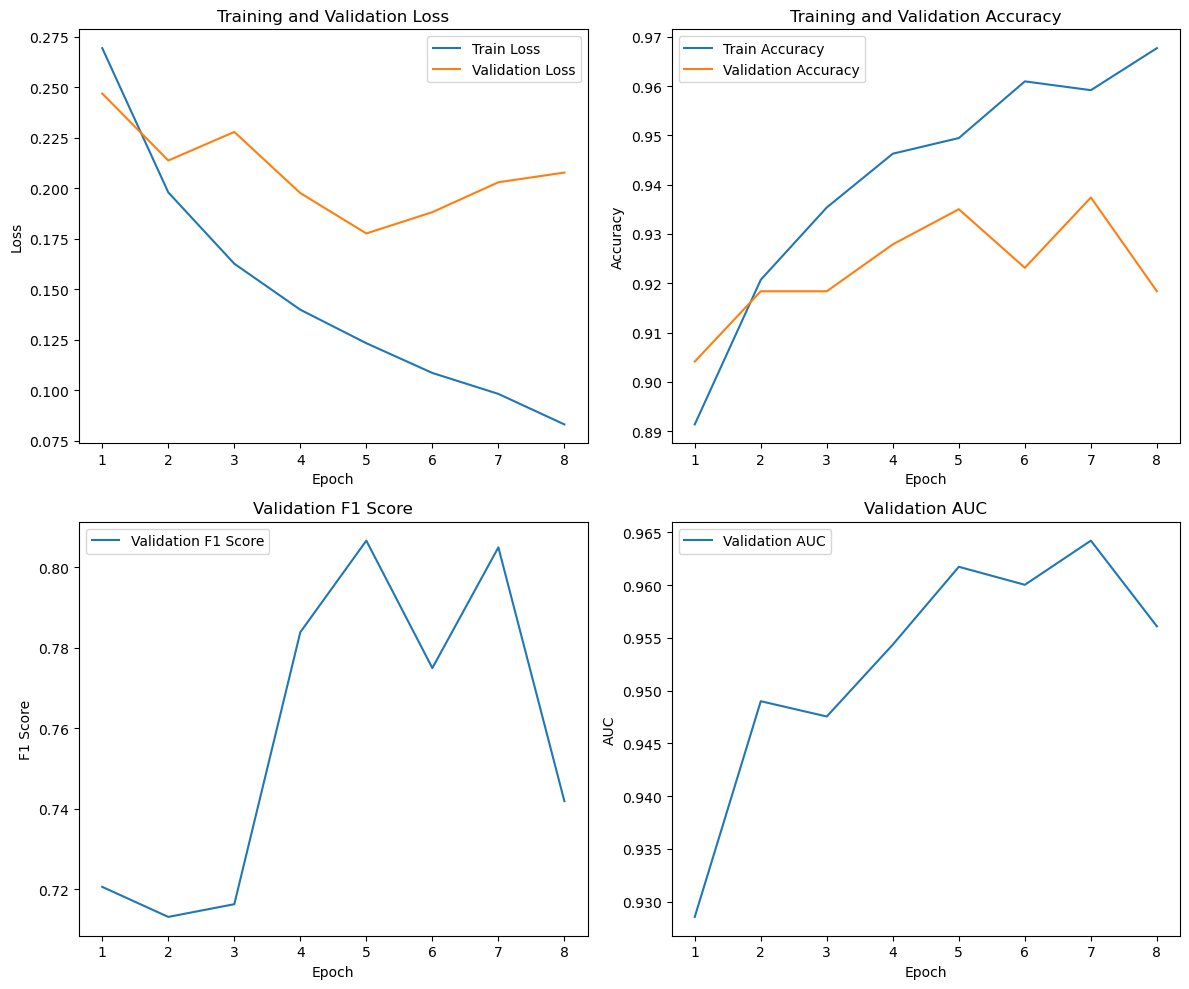

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.17764
fold,2
val_accuracy,0.92868
val_auc,0.96183
val_f1,0.78155


--- Fold 3/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.2783, Val Loss = 0.2040, Train Acc = 0.8868, Val Acc = 0.9199, Val F1 = 0.7139, Val AUC = 0.9461
Epoch 2: Train Loss = 0.1947, Val Loss = 0.1821, Train Acc = 0.9235, Val Acc = 0.9191, Val F1 = 0.7273, Val AUC = 0.9570
Epoch 3: Train Loss = 0.1566, Val Loss = 0.1835, Train Acc = 0.9358, Val Acc = 0.9255, Val F1 = 0.7459, Val AUC = 0.9595
Epoch 4: Train Loss = 0.1384, Val Loss = 0.1776, Train Acc = 0.9461, Val Acc = 0.9334, Val F1 = 0.7500, Val AUC = 0.9672
Epoch 5: Train Loss = 0.1204, Val Loss = 0.1931, Train Acc = 0.9493, Val Acc = 0.9247, Val F1 = 0.7689, Val AUC = 0.9579
Epoch 6: Train Loss = 0.0982, Val Loss = 0.1930, Train Acc = 0.9641, Val Acc = 0.9286, Val F1 = 0.7750, Val AUC = 0.9636
Epoch 7: Train Loss = 0.0879, Val Loss = 0.1745, Train Acc = 0.9645, Val Acc = 0.9334, Val F1 = 0.7971, Val AUC = 0.9705
Epoch 8: Train Loss = 0.0828, Val Loss = 0.1778, Train Acc = 0.9689, Val Acc = 0.9381, Val F1 = 0.7979, Val AUC = 0.9663
Epo

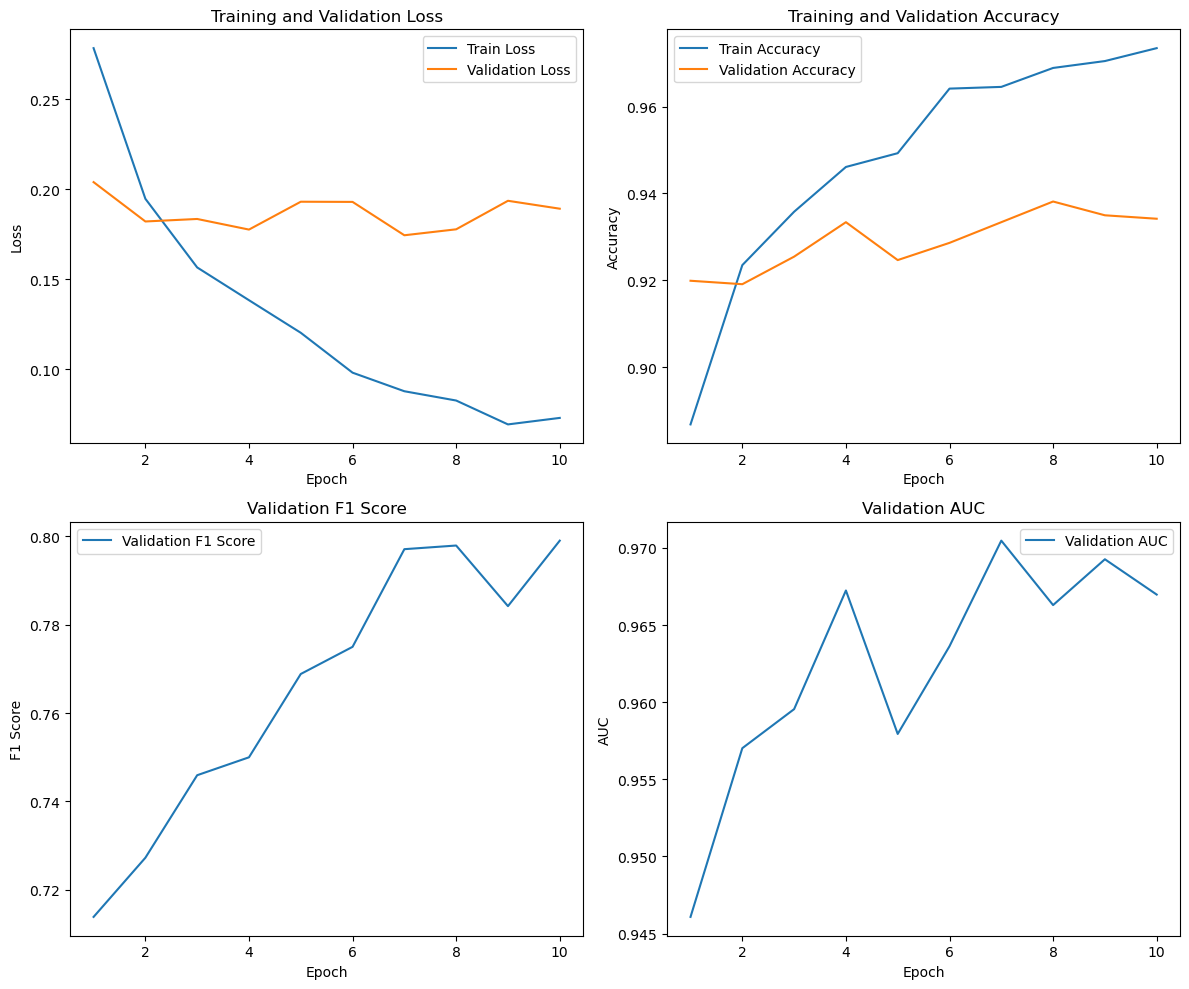

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.17447
fold,3
val_accuracy,0.93735
val_auc,0.9697
val_f1,0.8059


--- Fold 4/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.2721, Val Loss = 0.2244, Train Acc = 0.8964, Val Acc = 0.9175, Val F1 = 0.7204, Val AUC = 0.9363
Epoch 2: Train Loss = 0.1904, Val Loss = 0.2203, Train Acc = 0.9213, Val Acc = 0.9048, Val F1 = 0.6703, Val AUC = 0.9367
Epoch 3: Train Loss = 0.1618, Val Loss = 0.2007, Train Acc = 0.9334, Val Acc = 0.9167, Val F1 = 0.7541, Val AUC = 0.9551
Epoch 4: Train Loss = 0.1331, Val Loss = 0.2092, Train Acc = 0.9493, Val Acc = 0.9183, Val F1 = 0.7392, Val AUC = 0.9511
Epoch 5: Train Loss = 0.1176, Val Loss = 0.1930, Train Acc = 0.9530, Val Acc = 0.9255, Val F1 = 0.7360, Val AUC = 0.9642
Epoch 6: Train Loss = 0.1023, Val Loss = 0.1899, Train Acc = 0.9592, Val Acc = 0.9326, Val F1 = 0.7684, Val AUC = 0.9604
Epoch 7: Train Loss = 0.0947, Val Loss = 0.1669, Train Acc = 0.9637, Val Acc = 0.9318, Val F1 = 0.7749, Val AUC = 0.9669
Epoch 8: Train Loss = 0.0769, Val Loss = 0.2198, Train Acc = 0.9717, Val Acc = 0.9247, Val F1 = 0.7262, Val AUC = 0.9631
Epo

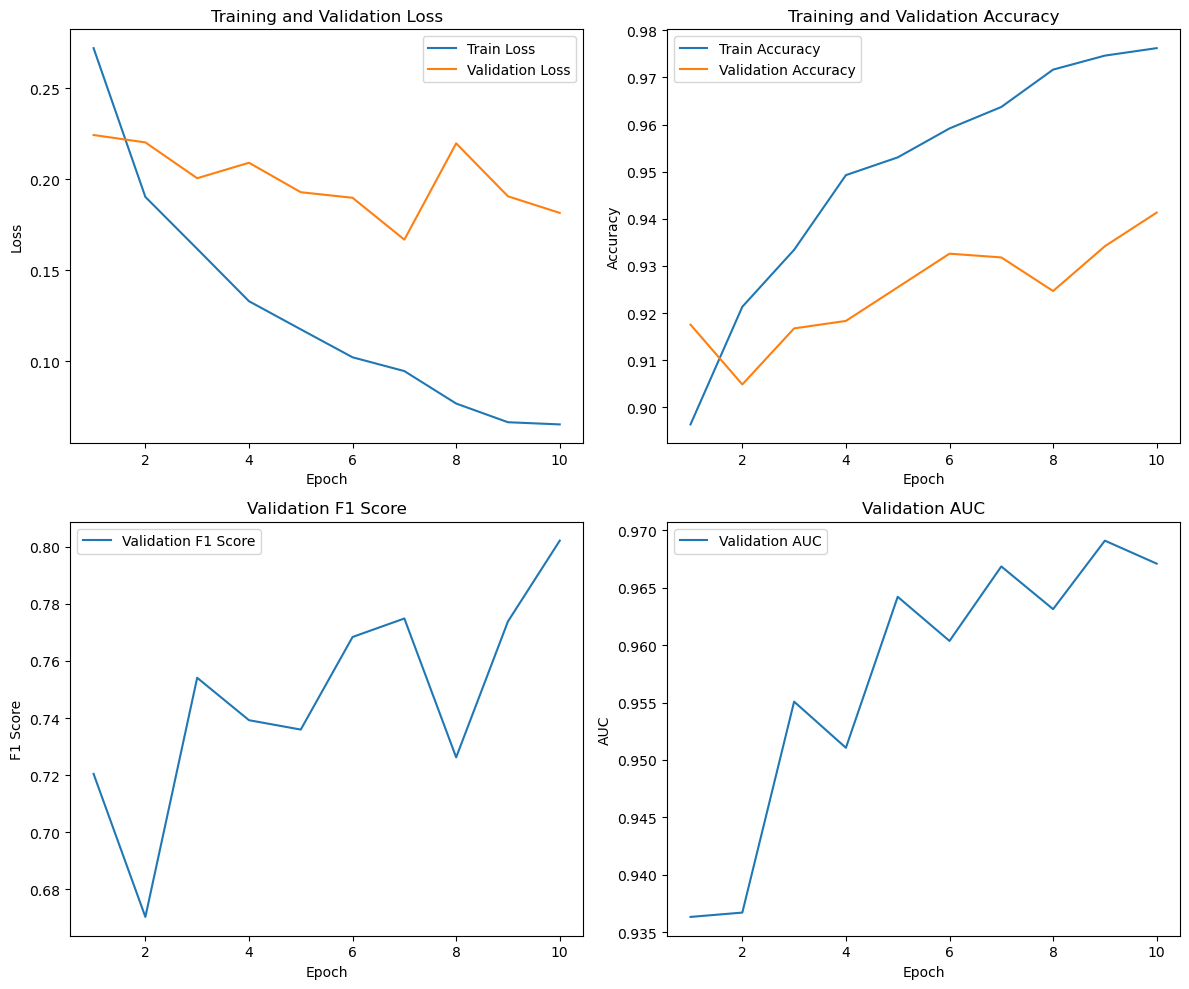

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.16691
fold,4
val_accuracy,0.9318
val_auc,0.96689
val_f1,0.76503


--- Fold 5/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.2775, Val Loss = 0.1898, Train Acc = 0.8884, Val Acc = 0.9199, Val F1 = 0.7263, Val AUC = 0.9555
Epoch 2: Train Loss = 0.1972, Val Loss = 0.1728, Train Acc = 0.9245, Val Acc = 0.9294, Val F1 = 0.7548, Val AUC = 0.9622
Epoch 3: Train Loss = 0.1606, Val Loss = 0.1850, Train Acc = 0.9378, Val Acc = 0.9286, Val F1 = 0.7353, Val AUC = 0.9640
Epoch 4: Train Loss = 0.1441, Val Loss = 0.1558, Train Acc = 0.9415, Val Acc = 0.9405, Val F1 = 0.8000, Val AUC = 0.9688
Epoch 5: Train Loss = 0.1224, Val Loss = 0.1917, Train Acc = 0.9520, Val Acc = 0.9247, Val F1 = 0.7875, Val AUC = 0.9684
Epoch 6: Train Loss = 0.1077, Val Loss = 0.1530, Train Acc = 0.9576, Val Acc = 0.9389, Val F1 = 0.8041, Val AUC = 0.9718
Epoch 7: Train Loss = 0.0990, Val Loss = 0.1496, Train Acc = 0.9598, Val Acc = 0.9461, Val F1 = 0.8229, Val AUC = 0.9717
Epoch 8: Train Loss = 0.0906, Val Loss = 0.1480, Train Acc = 0.9639, Val Acc = 0.9413, Val F1 = 0.7989, Val AUC = 0.9777
Epo

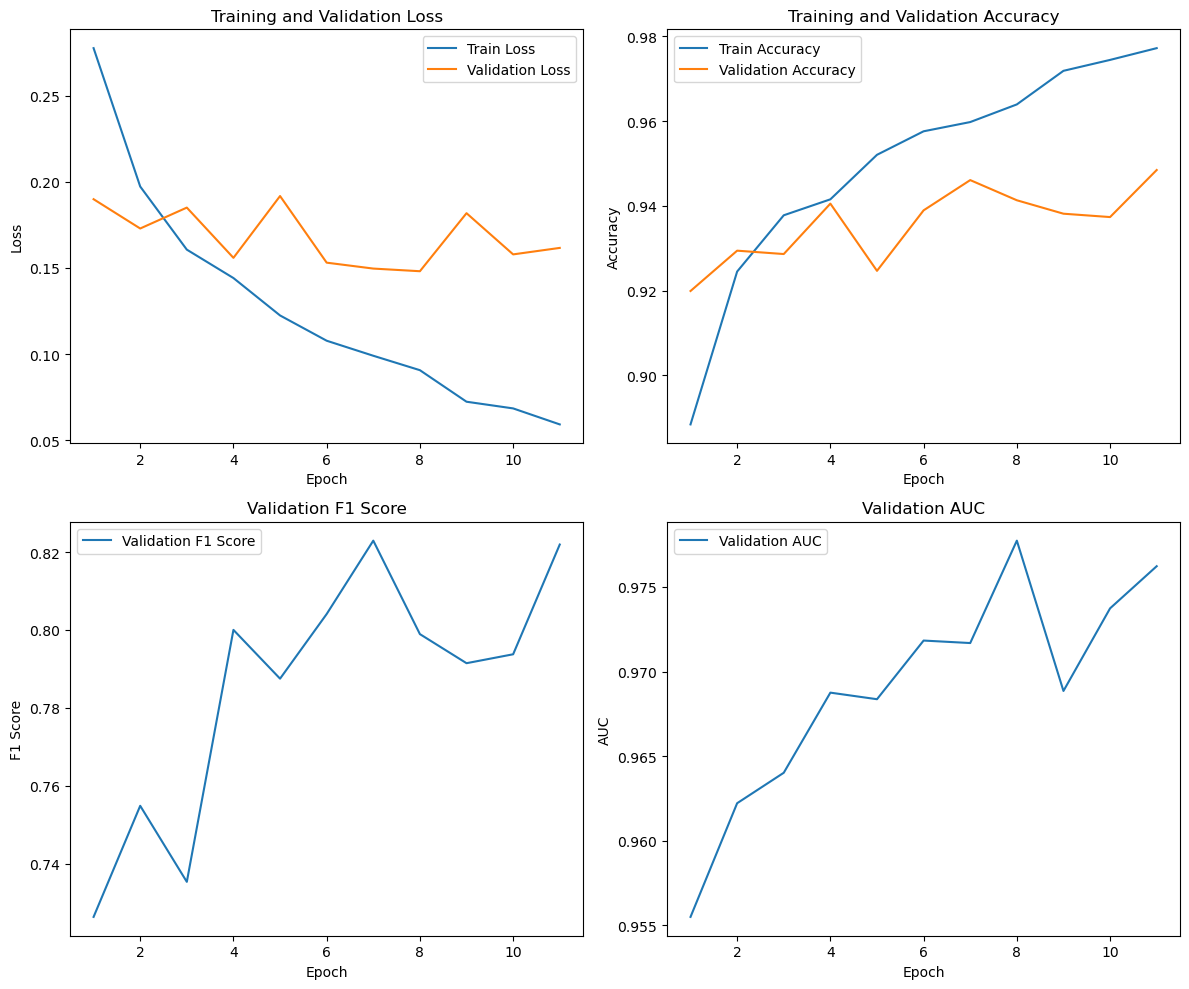

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.14804
fold,5
val_accuracy,0.94528
val_auc,0.96765
val_f1,0.80886


In [7]:
patience = 2
k_folds = 5  
epochs=13

batch_size = 8
weight_decay = 1.2852718112074654e-05
learning_rate=3.020842532706549e-05


kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_losses = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    
    print(f"--- Fold {fold+1}/{k_folds} ---")

    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model_Alex = VanGoghModel(device,None,'AlexNet').model
 
    optimizer_AlexNet = optim.Adam(model_Alex.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion_AlexNet = nn.BCELoss()

    wandb.init(
        project="Train_AlexNet",
        config={
            "model": "AlexNet",  
            "learning_rate": learning_rate,
            "weight_decay": weight_decay,
            "batch_size": batch_size,
            "k_folds": k_folds,
            "epochs": epochs,      
            "patience": patience
        },
        name=f"Train_AlexNet{fold+1}"
    )

    best_val_loss_AlexNet = train_model_with_hyperparams(
        model_Alex, train_loader, val_loader, optimizer_AlexNet, criterion_AlexNet, epochs=epochs, patience=patience
    )

    fold_losses.append(best_val_loss_AlexNet)

 
    model_Alex.eval()
    val_true = []
    val_pred = []
    val_probs = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_Alex(inputs).squeeze(1)  
            probs = outputs  
            preds = (probs > 0.5).float()
    
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(preds.cpu().numpy())
            val_probs.extend(probs.cpu().numpy())

    acc = accuracy_score(val_true, val_pred)
    auc = roc_auc_score(val_true, val_probs)
    f1 = f1_score(val_true, val_pred)

    wandb.log({
        "fold": fold+1,
        "best_val_loss_VGG19": best_val_loss_AlexNet,
        "val_accuracy": acc,
        "val_auc": auc,
        "val_f1": f1
    })
    
    wandb.finish()


